In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm

import matplotlib.pyplot as plt
import os

from sklearn.model_selection import GroupKFold, cross_val_predict
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.gridspec as gridspec


/gpfs/gibbs/project/sanford/asu5/conda_envs/deforest6/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/1 [00:00<?, ?it/s]

Set to create new indices for test train split and cross validation
[2004 2005 2006 2007]
(665048, 216)
Test set pct of data: 30.002044965175443
New test/train indices generated and saved in TestTrainSplit


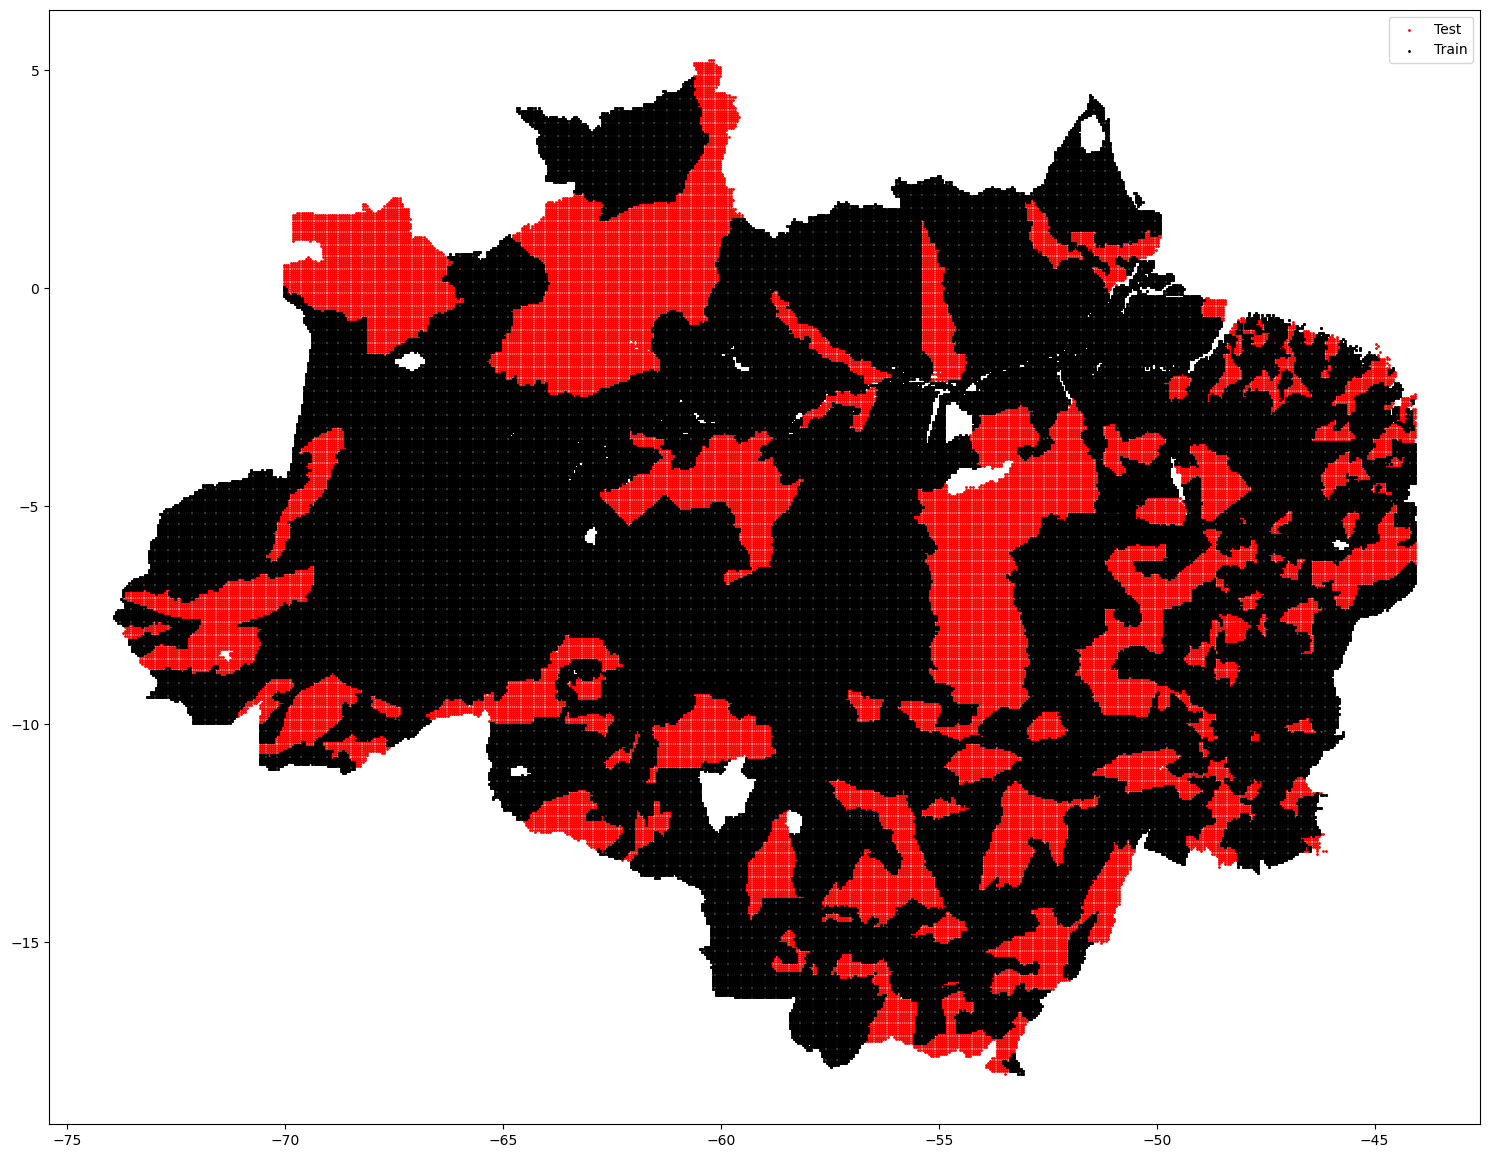

[2007]
[2004 2005 2006]
New cross validation indices generated and read in
{'year': 0, 'rain1': 0, 'elevation': 0, 'slope': 0, 'aspect': 0, 'near_mines': 0, 'near_roads': 0, 'near_hidrovia': 0, 'indigenous_homol': 0, 'mun_election_year': 0, 'new_forest_code': 0, 'lula': 0, 'dilma': 0, 'temer': 0, 'bolsonaro': 0, 'fed_election_year': 0, 'populacao': 0, 'pib_pc': 0, 'ironore': 0, 'silver': 0, 'copper': 0, 'gold': 0, 'soy_price': 0, 'beef_price': 0, 'ag_jobs': 0, 'mining_jobs': 0, 'public_jobs': 0, 'construction_jobs': 0, 'PIB': 0, 'n_companies_PUBLIC ADMIN': 0, 'n_companies_AGRICULTURE': 0, 'n_companies_FOOD AND DRINKS': 0, 'n_companies_ACCOMODATION AND FOOD': 0, 'n_companies_EQUIPMENT RENTAL': 0, 'n_companies_WHOLESALE': 0, 'n_companies_ASSOCIATIVE ACTIVITIES': 0, 'n_companies_AUTOMOBILES AND TRANSPORT': 0, 'n_companies_FINANCIAL ASSISTANCE': 0, 'n_companies_TRADE REP VEHICLES': 0, 'n_companies_CONSTRUCTION': 0, 'n_companies_MAIL AND TELECOM': 0, 'n_companies_CULTURE AND SPORT': 0, 'n_c

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.369e+00, tolerance: 2.586e-01


[CV 1/5] END ...............model__alpha=0.001;, score=-0.000 total time=  23.2s


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.659e+00, tolerance: 2.683e-01


[CV 2/5] END ...............model__alpha=0.001;, score=-0.000 total time=  23.1s


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.790e+00, tolerance: 2.268e-01


[CV 3/5] END ...............model__alpha=0.001;, score=-0.001 total time=  22.6s


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.665e+00, tolerance: 2.017e-01


[CV 4/5] END ...............model__alpha=0.001;, score=-0.002 total time=  21.3s


In [2]:

first_time = True

for this_start_year in tqdm([2004]):
    SUBSET = False
    SUBSET_SIZE = 100

    
    if first_time: 
        NEW_INDICES = True
        NEW_CV_INDICES = True
        first_time = False
        print('Set to create new indices for test train split and cross validation')
    else: 
        NEW_INDICES = False
        NEW_CV_INDICES = False
        print('Reading previous iteration test train split indices and cross validation indices')
    

    PLOT_ENTIRE_AREA = True
    PLOT_FOLDS = False

    START_YEAR_TRAIN = this_start_year
    NUMBER_YEARS_TRAIN = 3
    YEARS_TO_TRAIN = [START_YEAR_TRAIN + i  for i in range(NUMBER_YEARS_TRAIN + 1)]

    PREDICT_YEAR = START_YEAR_TRAIN + NUMBER_YEARS_TRAIN

    FOLDER_NAME = ''.join([f'{START_YEAR_TRAIN + i}_' for i in list(range(NUMBER_YEARS_TRAIN))]) + f'PREDICT_{PREDICT_YEAR}'


    FILE_PATH = f'FeatureImportanceResults/{FOLDER_NAME}/'

    if not os.path.exists(f'FeatureImportanceResults/{FOLDER_NAME}'):
        os.makedirs(f'FeatureImportanceResults/{FOLDER_NAME}')
        
    if not os.path.exists(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices'):
        os.makedirs(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices')

    if not os.path.exists(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit'):
        os.makedirs(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit')
    
    if not os.path.exists(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation'):
        os.makedirs(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation')

    if not os.path.exists(f'FeatureImportanceResults/TestTrainIndices'):
        os.makedirs(f'FeatureImportanceResults//TestTrainIndices')
    if not os.path.exists(f'FeatureImportanceResults/TestTrainIndices/TestTrainSplit'):
        os.makedirs(f'FeatureImportanceResults//TestTrainIndices/TestTrainSplit')
    
    if not os.path.exists(f'FeatureImportanceResults/TestTrainIndices/CrossValidation'):
        os.makedirs(f'FeatureImportanceResults/TestTrainIndices/CrossValidation')
        
        
    df_full = pd.read_csv(f'FinalData/FinalData{START_YEAR_TRAIN}_1.csv')
    df_full = pd.concat([df_full, pd.read_csv(f'FinalData/FinalData{START_YEAR_TRAIN}_2.csv')])
    df_full = pd.concat([df_full, pd.read_csv(f'FinalData/FinalData{START_YEAR_TRAIN}_3.csv')])
    df_full = pd.concat([df_full, pd.read_csv(f'FinalData/FinalData{START_YEAR_TRAIN}_4.csv')])


    for year in YEARS_TO_TRAIN[1:]:
        filename = f'FinalData/FinalData{str(year)}_1.csv'
        df_full = pd.concat([df_full, pd.read_csv(filename)])
        filename = f'FinalData/FinalData{str(year)}_2.csv'
        df_full = pd.concat([df_full, pd.read_csv(filename)])
        filename = f'FinalData/FinalData{str(year)}_3.csv'
        df_full = pd.concat([df_full, pd.read_csv(filename)])
        filename = f'FinalData/FinalData{str(year)}_4.csv'
        df_full = pd.concat([df_full, pd.read_csv(filename)])

    print(np.unique(df_full.year))
    print(df_full.shape)


    X_cols  = ['year', 'rain1', 'elevation', 'slope', 'aspect', 'near_mines',
        'near_roads', 'near_hidrovia', 'indigenous_homol',
        'mun_election_year', 'new_forest_code', 'lula', 'dilma', 'temer',
        'bolsonaro', 'fed_election_year', 'populacao', 'pib_pc', 'ironore',
        'silver', 'copper', 'gold', 'soy_price', 'beef_price', 'ag_jobs',
        'mining_jobs', 'public_jobs', 'construction_jobs', 'PIB',
        'n_companies_PUBLIC ADMIN', 'n_companies_AGRICULTURE',
        'n_companies_FOOD AND DRINKS', 'n_companies_ACCOMODATION AND FOOD',
        'n_companies_EQUIPMENT RENTAL', 'n_companies_WHOLESALE',
        'n_companies_ASSOCIATIVE ACTIVITIES',
        'n_companies_AUTOMOBILES AND TRANSPORT',
        'n_companies_FINANCIAL ASSISTANCE',
        'n_companies_TRADE REP VEHICLES', 'n_companies_CONSTRUCTION',
        'n_companies_MAIL AND TELECOM', 'n_companies_CULTURE AND SPORT',
        'n_companies_EDITING AND PRINTING', 'n_companies_EDUCATION',
        'n_companies_ELECTRICITY AND GAS', 'n_companies_FINANCES',
        'n_companies_CLEANING AND SEWAGE', 'n_companies_MACHINERY',
        'n_companies_BASIC METALLURGY', 'n_companies_MINING',
        'n_companies_WOOD PROD',
        'n_companies_NON-METALLIC MINERAL PRODUCTS', 'n_companies_HEALTH',
        'n_companies_SERVICES FOR COMPANIES',
        'n_companies_PERSONAL SERVICES', 'n_companies_TRANSPORTATION',
        'n_companies_GROUND TRANSPORT',
        'n_companies_WATER TREATMENT AND DISTRIBUTION',
        'n_companies_RETAIL', 'n_companies_COMPUTING',
        'n_companies_INSURANCE AND SOCIAL SECURITY',
        'n_companies_METALLIC PRODUCTS', 'n_companies_DOMESTIC SERVICES',
        'n_companies_FORESTRY', 'n_companies_CLOTHING',
        'n_companies_PAPER', 'n_companies_INTERNATIONAL BODIES',
        'n_companies_OIL AND GAS', 'n_companies_FISHING AND AQUACULTURE',
        'n_companies_CHEMICALS', 'n_companies_WATER-BASED TRANSPORTATION',
        'n_companies_REAL ESTATE', 'n_companies_RECYCLING',
        'n_companies_LEATHERS AND FOOTWEAR',
        'n_companies_RUBBER AND PLASTIC', 'n_companies_TEXTILES',
        'n_companies_RESEARCH AND DEVELOPMENT',
        'n_companies_AERO TRANSPORT', 'n_companies_SMOKE',
        'n_companies_PETROLEUM REFINING', 'n_companies_',
        'n_jobs_PUBLIC ADMIN', 'n_jobs_AGRICULTURE',
        'n_jobs_FOOD AND DRINKS', 'n_jobs_ACCOMODATION AND FOOD',
        'n_jobs_EQUIPMENT RENTAL', 'n_jobs_WHOLESALE',
        'n_jobs_ASSOCIATIVE ACTIVITIES',
        'n_jobs_AUTOMOBILES AND TRANSPORT', 'n_jobs_FINANCIAL ASSISTANCE',
        'n_jobs_TRADE REP VEHICLES', 'n_jobs_CONSTRUCTION',
        'n_jobs_MAIL AND TELECOM', 'n_jobs_CULTURE AND SPORT',
        'n_jobs_EDITING AND PRINTING', 'n_jobs_EDUCATION',
        'n_jobs_ELECTRICITY AND GAS', 'n_jobs_FINANCES',
        'n_jobs_CLEANING AND SEWAGE', 'n_jobs_MACHINERY',
        'n_jobs_BASIC METALLURGY', 'n_jobs_MINING', 'n_jobs_WOOD PROD',
        'n_jobs_NON-METALLIC MINERAL PRODUCTS', 'n_jobs_HEALTH',
        'n_jobs_SERVICES FOR COMPANIES', 'n_jobs_PERSONAL SERVICES',
        'n_jobs_TRANSPORTATION', 'n_jobs_GROUND TRANSPORT',
        'n_jobs_WATER TREATMENT AND DISTRIBUTION', 'n_jobs_RETAIL',
        'n_jobs_COMPUTING', 'n_jobs_INSURANCE AND SOCIAL SECURITY',
        'n_jobs_METALLIC PRODUCTS', 'n_jobs_DOMESTIC SERVICES',
        'n_jobs_FORESTRY', 'n_jobs_CLOTHING', 'n_jobs_PAPER',
        'n_jobs_INTERNATIONAL BODIES', 'n_jobs_OIL AND GAS',
        'n_jobs_FISHING AND AQUACULTURE', 'n_jobs_CHEMICALS',
        'n_jobs_WATER-BASED TRANSPORTATION', 'n_jobs_REAL ESTATE',
        'n_jobs_RECYCLING', 'n_jobs_LEATHERS AND FOOTWEAR',
        'n_jobs_RUBBER AND PLASTIC', 'n_jobs_TEXTILES',
        'n_jobs_RESEARCH AND DEVELOPMENT', 'n_jobs_AERO TRANSPORT',
        'n_jobs_SMOKE', 'n_jobs_PETROLEUM REFINING', 'n_jobs_',
        'n_jobs_TOTAL INDUSTRIAL', 'n_jobs_TOTAL SERVICE',
        'n_companies_TOTAL INDUSTRIAL', 'n_companies_TOTAL SERVICE',
        'n_companies_TOTAL', 'n_jobs_TOTAL', 'murder_threats',
        'assassination', 'assassination_attempt', 'f_emitted_count',
        'expen_agri', 'expen_env_man', 'expen_agr_org', 'expen_mining',
        'expen_petrol', 'expen_prom_ani_pro', 'expen_prom_veg_pro',
        'expen_other_agr', 'expen_agr_defense', 'expen_min_fuel',
        'illegal_mining', 'illegal_other', 'illegal_industry', 'audits',
        'emiss_pec_full', 'emiss_agr_full', 'emiss_agropec_full',
        'incumbant', 'term_limited_seat', 'special',
        'overall_winner_complete_college', 
        'overall_winner_feminino', 'overall_winner_agriculture_job',
        'overall_winner_public_service_job', 'overall_winner_health_job',
        'overall_winner_corporate_job', 'overall_winner_law_job',
        'overall_winner_technical_job', 'overall_winner_professional_job',
        'overall_winner_mining_job', 'overall_winner_partido_PT',
        'overall_winner_partido_PMDB_MDB', 'overall_winner_partido_PSDB',
        'overall_winner_partido_DEM', 'overall_winner_partido_PL',
        'overall_winner_partido_other', 'runnerup_partido_PT',
        'runnerup_partido_PMDB_MDB', 'runnerup_partido_PSDB',
        'runnerup_partido_DEM', 'runnerup_partido_PL',
        'runnerup_partido_other', 'winner_votes_proportion',
        'vote_participation_proportion',
        'forest_formation', 'savanna', 'mangrove', 'silvicultura',
        'pasture', 'sugarcane', 'mosaic_ag', 'urban', 'mining', 'water',
        'soybean', 'rice', 'other_crop', 'coffee', 'citrus',
        'other_perennial', 'forest_lag']


    #'runnerup_votes_proportion', 
    #'overall_winner_idade',


    ## Test train split
    #split into two groups where no muni in train set is tested
    #then do a second split by year so that the train years are year n, n+1, n+2 and the test set uses n+3.
    if SUBSET:
        df_full = df_full.sample(SUBSET_SIZE).reset_index(drop=True)


    Y = df_full['forest_diff']
    X = df_full[X_cols]
    # gdf = gpd.GeoDataFrame(X, geometry = gpd.points_from_xy(df_full.x, df_full.y))
    # XYs = gdf['geometry']


    if NEW_INDICES:

        #Select Test/Train Indices
        n_folds = 10 
        munis = df_full['ID'].values
        group_kfold = GroupKFold(n_splits = n_folds)
        muni_kfold = group_kfold.split(X, Y, munis) 
        train_indices, test_indices = [list(traintest) for traintest in zip(*muni_kfold)]
        city_cv = [*zip(train_indices,test_indices)]

        test_inds = []
        for i in range(3):
            test_inds.extend(city_cv[i][1])

        train_inds = []
        for i in range(3, 10):
            train_inds.extend(city_cv[i][1])

        print(f'Test set pct of data: {len(test_inds)/(len(train_inds) + len(test_inds)) * 100}')


        np.save('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/test_inds.npy', test_inds)
        np.save('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/train_inds.npy', train_inds)
        np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/train_inds.npy', train_inds)
        np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/test_inds.npy', test_inds)
        print('New test/train indices generated and saved in TestTrainSplit')

    if not NEW_INDICES:
        test_inds = np.load('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/test_inds.npy')
        train_inds = np.load('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/train_inds.npy')
        np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/train_inds.npy', train_inds)
        np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/test_inds.npy', test_inds)
        print('Existing test/train indices read in from previous iteration')


    #Split data into test/train sets

    df_full_test = df_full.iloc[test_inds].reset_index(drop=True)
    df_full_train = df_full.iloc[train_inds].reset_index(drop=True)

    #test data has only the last year with unseen spatial samples
    df_full_test = df_full_test[df_full_test.year == PREDICT_YEAR]

    #train data has only the 3 train years 
    df_full_train = df_full_train[df_full_train.year < PREDICT_YEAR]

    Y_test = df_full_test['forest_diff']
    Y_train = df_full_train['forest_diff']

    X_test = df_full_test[X_cols]
    X_train = df_full_train[X_cols]

    gdf_test = gpd.GeoDataFrame(X_test, geometry = gpd.points_from_xy(df_full_test.x, df_full_test.y))
    gdf_train = gpd.GeoDataFrame(X_train, geometry = gpd.points_from_xy(df_full_train.x, df_full_train.y))

    XYs_test = gdf_test['geometry']
    XYs_train = gdf_train['geometry']

    if PLOT_ENTIRE_AREA and NEW_INDICES:
        fig, axs = plt.subplots(1, 1, figsize=(15, 12))
        marker_size = 0.1
        marker_size = 1
        XYs_test.plot(ax=axs, color = 'red', markersize=marker_size, label = 'Test')
        XYs_train.plot(ax=axs, color = 'black', markersize=marker_size, label = 'Train')

        plt.legend(markerscale=1)
        plt.tight_layout()

        # Save the figure
        plt.savefig(FILE_PATH + 'EntirePlot')

        plt.show()

    print(np.unique(df_full_test.year))
    print(np.unique(df_full_train.year))



    if NEW_CV_INDICES:
        #Select Cross Validation Fold Indices: 

        n_folds = 5
        munis = df_full_train['ID'].values
        group_kfold = GroupKFold(n_splits = n_folds)
        
        
        # Generator for the train/test indices
        muni_kfold = group_kfold.split(X_train, Y_train, munis) 

        # Create a nested list of train and test indices for each fold
        train_indices, test_indices = [list(traintest) for traintest in zip(*muni_kfold)]
        muni_cv = [*zip(train_indices,test_indices)]
        

        #save train and test indices 
        for i in range(len(train_indices)):
            np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation/train_indices_{i}.txt', train_indices[i])
            np.savetxt(f'FeatureImportanceResults/TestTrainIndices/CrossValidation/train_indices_{i}.txt', train_indices[i])

        for i in range(len(test_indices)):
            np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation/test_indices_{i}.txt', test_indices[i])
            np.savetxt(f'FeatureImportanceResults/TestTrainIndices/CrossValidation/test_indices_{i}.txt', test_indices[i])

        #np.save('FeatureImportanceResults/muni_cv.npy', muni_cv)
        print('New cross validation indices generated and read in')
        


    if not NEW_CV_INDICES:
        NUM_FOLDS = 5
        #read in train and test indices
        train_indices = []
        for i in range(NUM_FOLDS):

            train_indices.append(np.loadtxt(f'FeatureImportanceResults/TestTrainIndices/CrossValidation/train_indices_{i}.txt').astype(int))

        test_indices = []
        for i in range(NUM_FOLDS):
            test_indices.append(np.loadtxt(f'FeatureImportanceResults/TestTrainIndices/CrossValidation/test_indices_{i}.txt').astype(int))

        #save train and test indices 
        for i in range(NUM_FOLDS):
            np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation/train_indices_{i}.txt', train_indices[i])

        for i in range(NUM_FOLDS):
            np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation/test_indices_{i}.txt', test_indices[i])

        muni_cv = [*zip(train_indices,test_indices)]
        #muni_cv = np.load('muni_cv.npy')
        
        print('Existing cross validation indices read in from previous iteration')


    if PLOT_FOLDS and NEW_CV_INDICES: 
        fig, axs = plt.subplots(1, n_folds, figsize=(25, 16))
        marker_size = 0.01

        for i in range(n_folds):
            ax = axs[i]

            this_train_inds = muni_cv[i][0]
            this_test_inds = muni_cv[i][1]
            XYs_train[this_test_inds].plot(ax=ax, color = 'red', markersize=marker_size, label = 'Test')
            XYs_train[this_train_inds].plot(ax=ax, color = 'black', markersize=marker_size, label = 'Train')
            ax.set_title(f"Fold {i+1}")

        #plt.suptitle(f'{n_folds}-Fold Spatial Cross Validation ') 
        # handles, labels = ax.get_legend_handles_labels()
        # fig.legend(handles, labels)   

        for ax in axs.flat:
            ax.set_axis_off()


        plt.legend(markerscale=100)
        plt.tight_layout()
        plt.savefig(FILE_PATH + 'FoldPlot')
        plt.show()



    # Count null values in each column
    null_counts = {col: X_train[col].isnull().sum() for col in X_train.columns}

    # Sort the dictionary in descending order based on the values
    sorted_null_counts = dict(sorted(null_counts.items(), key=lambda item: item[1], reverse=True))

    print(sorted_null_counts)

    X_train = X_train.drop('geometry', axis = 1)
    X_test = X_test.drop('geometry', axis = 1)

    with open(FILE_PATH + 'performance.txt', 'w+') as f:
            f.write(f'MODEL PERFORMANCES\n')

    def generate_results_table(coef_input, key_input, name_input, yhat, normalized = True):
        if normalized: 
            coef_input = coef_input / sum(coef_input)

        #write MSE to file 
        mse = mean_squared_error(Y_test, yhat)
        print(f'{name_input} MSE: {mse}')

        with open(FILE_PATH + 'performance.txt', 'a') as f:
            f.write(f'\n{name_input} MSE: {mse}')


        features_df = pd.DataFrame([key_input, coef_input]).T
        features_df.columns = ['Feature', 'Coeff']

        features_df = features_df.iloc[features_df['Coeff'].abs().argsort()[::-1]]
        features_df.to_csv(f'{FILE_PATH}{name_input}.csv')

        return features_df


    base_learners = []

    yhat_list = []




    #random forest
    pipeline = Pipeline([
                        ('scaler',StandardScaler()),
                        ('model',RandomForestRegressor(n_estimators = 500))
    ])

    search = GridSearchCV(pipeline,
                        {'model__max_depth': np.arange(3,11,8) },
                        cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                        )

    search.fit(X_train,Y_train)

    base_learners.append(('randomforest', search.best_estimator_))

    coefficients = search.best_estimator_._final_estimator.feature_importances_
    importance = np.abs(coefficients)

    yhat = search.best_estimator_.predict(X_test)
    yhat_list.append(yhat)

    randomforest_features_df = generate_results_table(coefficients, X_train.columns, 'randomforest', yhat)

    X_train.columns[np.argsort(np.array(abs( importance )))[::-1][0:9]]



    #lasso 

    pipeline = Pipeline([
                        ('scaler',StandardScaler()),
                        ('model',Lasso())
    ])

    search = GridSearchCV(pipeline,
                        {'model__alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]},
                        cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                        )

    search.fit(X_train,Y_train)
    base_learners.append(('lasso', search.best_estimator_))

    coefficients = search.best_estimator_.named_steps['model'].coef_
    importance = np.abs(coefficients)

    yhat = search.best_estimator_.predict(X_test)
    yhat_list.append(yhat)

    lasso_features_df = generate_results_table(coefficients, X_train.columns, 'lasso', yhat = yhat)

    X_train.columns[np.argsort(np.array(abs( importance )))[::-1][0:9]]






    #Gradient boosting

    pipeline = Pipeline([
                        ('scaler',StandardScaler()),
                        ('model',GradientBoostingRegressor(learning_rate = 0.1, min_samples_leaf = 2))
    ])

    search = GridSearchCV(pipeline,
                        {'model__n_estimators':np.arange(50, 150, 50), 'model__max_depth':np.arange(3, 5, 1)},
                        cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                        )

    search.fit(X_train,Y_train)

    search.best_params_

    base_learners.append(('gradientboosting', search.best_estimator_.named_steps['model']))

    coefficients = search.best_estimator_.named_steps['model'].feature_importances_
    importance = np.abs(coefficients)

    yhat = search.best_estimator_.predict(X_test)
    yhat_list.append(yhat)

    gradient_boosting_features_df = generate_results_table(coefficients, X_train.columns, 'gradientboosting', yhat)


    X.columns[np.argsort(np.array(abs( importance )))[::-1][0:9]]




    #neural network

    pipeline = Pipeline([
                        ('scaler',StandardScaler()),
                        ('model', MLPRegressor(activation = 'logistic', random_state=42))
    ])

    search = GridSearchCV(pipeline,
                        {'model__hidden_layer_sizes':[(50,),(100,)], 'model__alpha':np.arange(0.00001, 0.001, 0.001)},
                        cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                        )

    search.fit(X_train,Y_train)

    base_learners.append(('neuralnetwork', search.best_estimator_))

    explainer = shap.KernelExplainer(search.best_estimator_.predict, X_train)

    shap_values = explainer.shap_values(X_test, nsamples=1000)

    shap.summary_plot(shap_values,X_test,feature_names=X_test.columns)

    feature_names = X_train.columns

    rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

    vals = np.abs(rf_resultX.values).mean(0)

    shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                    columns=['col_name','feature_importance_vals'])
    shap_importance.sort_values(by=['feature_importance_vals'],
                                ascending=False, inplace=True)

    #shap_importance.to_csv('FeatureInportanceResults/neuralnetwork.csv')

    yhat = search.best_estimator_.predict(X_test)
    yhat_list.append(yhat)

    nn_features_df = generate_results_table(np.array(shap_importance.feature_importance_vals), np.array(shap_importance.col_name), 'neuralnetwork', yhat)






    #super learner ensemble
    def get_models():
        base_models = []
        #Random forest regressor
        base_models.append(base_learners[0][1][1])
        #Lasso
        base_models.append(base_learners[1][1][1])
        #Gradient Boosting
        base_models.append(base_learners[2][1])
        #NeuralNetwork
        base_models.append(base_learners[3][1][1])
        return base_models

    def get_out_of_fold_predictions(X_train, Y_train, base_models):
        meta_X = []
        meta_Y = []

        # enumerate splits
        for train_ix, test_ix in muni_cv:
            fold_yhats = []
            meta_train_X, meta_test_X = X_train.iloc[train_ix], X_train.iloc[test_ix]
            meta_train_Y, meta_test_Y = Y_train.iloc[train_ix], Y_train.iloc[test_ix]
            meta_Y.extend(meta_test_Y)

            # fit and make predictions with each sub-model
            for model in base_models:
                model.fit(meta_train_X, meta_train_Y)
                yhat = model.predict(meta_test_X)
                # store columns
                fold_yhats.append(yhat.reshape(len(yhat),1))
        
            meta_X.append(np.hstack(fold_yhats))
                
        return np.vstack(meta_X), np.asarray(meta_Y)

    def super_learner_predictions(X, models, meta_model):
        meta_X = []
        for model in models:
            yhat = model.predict(X) 
            meta_X.append(yhat)
        # predict
        return meta_model.predict(pd.DataFrame(meta_X).T)
        
    def fit_base_models(X, y, models):
        for model in models:
            model.fit(X, y)
    

    def fit_meta_model(X, y):
        model = Ridge()
        model.fit(X, y)
        return model

    def evaluate_models(X, y, models):
        for model in models:
            yhat = model.predict(X)
            mse = mean_squared_error(y, yhat)
            print('%s: %.3f' % (model.__class__.__name__, mse))

    # get models
    models = get_models()
    # get out of fold predictions
    meta_X, meta_y = get_out_of_fold_predictions(X_train, Y_train, models)
    print('Meta Data Shape: ', meta_X.shape, meta_y.shape)

    fit_base_models(X_train, Y_train, models)
    meta_model = fit_meta_model(meta_X, meta_y)

    evaluate_models(X_test, Y_test, models)

    yhat = super_learner_predictions(X_test, models, meta_model)
    yhat_list.append(yhat)

    # Evaluate the performance of the model
    mse = mean_squared_error(Y_test, yhat)
    print("MSE:", mse)


    #Super Learner Feature Importance

    #Random forest 
    random_forest_weighted_importance = models[0].feature_importances_ * meta_model.coef_[0]

    #Lasso 
    lasso_weighted_importance = models[1].coef_ * meta_model.coef_[1]

    #GradientBoostingRegressor
    gradient_boosting_weighted_importance = models[2].feature_importances_ * meta_model.coef_[2]

    #NeuralNetwork
    explainer = shap.KernelExplainer(models[2].predict, X_train)
    shap_values = explainer.shap_values(X_test, nsamples=100)

    feature_names = X_train.columns

    rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

    vals = np.abs(rf_resultX.values).mean(0)

    shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                    columns=['col_name','feature_importance_vals'])


    nn_weighted_importance = shap_importance.feature_importance_vals * meta_model.coef_[3]


    super_learner_feature_importance = np.mean([random_forest_weighted_importance, lasso_weighted_importance, gradient_boosting_weighted_importance, nn_weighted_importance], axis = 0)


    super_learner_features_df = generate_results_table(super_learner_feature_importance, X_train.columns, 'superlearner', yhat)



    #visualize

    prediction_df = -pd.DataFrame(yhat_list).T
    prediction_df.columns = ['randomforest', 'lasso', 'gradientboosting', 'nn', 'superlearner']
    prediction_df['avg'] = prediction_df.mean(axis=1)
    prediction_df['x'] = np.array(df_full_test['x'])
    prediction_df['y'] = np.array(df_full_test['y'])
    prediction_df['actual']  = -np.array(Y_test)
    prediction_df.to_csv(FILE_PATH + 'predictions.csv')

    for col_name in ['randomforest', 'lasso', 'gradientboosting', 'nn', 'superlearner', 'avg']:
        gdf_yhat = gpd.GeoDataFrame(prediction_df, geometry = gpd.points_from_xy(prediction_df.x, prediction_df.y))
        fig, axs = plt.subplots(1, 1, figsize=(15, 12))
        marker_size = 1
        gdf_yhat.plot(column = col_name, cmap = 'Reds', ax=axs, markersize = marker_size)

        #plt.legend(markerscale=1)
        plt.tight_layout()

        

        # Show the colorbar
        sm = plt.cm.ScalarMappable(cmap = 'Reds')
        sm.set_array(prediction_df['avg'])
        cbar = plt.colorbar(sm)
        

        # Save the figure
        plt.savefig(FILE_PATH + 'DeforestPlot_' + col_name)

        plt.show()

